In [123]:
import numpy as np
from hdf5storage import loadmat,savemat
import matplotlib.pyplot as plt
import pandas as pd

In [124]:
sub = '105'
ses3 = loadmat('../data/Subject105/105Session3/Subject105_roi_data2.hdf.mat')
ses4 = loadmat('../data/Subject105/105Session4/Subject105_roi_data2.hdf.mat')

In [125]:
passNoseTrials = np.concatenate([ses3['processed_pass_nose'],ses4['processed_pass_nose']],axis=0)
passForeheadTrials = np.concatenate([ses3['processed_pass_forehead'],ses4['processed_pass_forehead']],axis=0)
passCheekTrials = np.concatenate([ses3['processed_pass_cheek'],ses4['processed_pass_cheek']],axis=0)
# passRightTrials = np.concatenate([ses3['processed_pass_right_cheek'],ses4['processed_pass_right_cheek']],axis=0)
keepNoseTrials = np.concatenate([ses3['processed_keep_nose'],ses4['processed_keep_nose']],axis=0)
keepForeheadTrials = np.concatenate([ses3['processed_keep_forehead'],ses4['processed_keep_forehead']],axis=0)
keepCheekTrials = np.concatenate([ses3['processed_keep_cheek'],ses4['processed_keep_cheek']],axis=0)
# keepRightTrials = np.concatenate([ses3['processed_keep_right_cheek'],ses4['processed_keep_right_cheek']],axis=0)
time = np.arange(-1000,10500,50)


In [126]:

def makefiltersos(sr,fp,fs,gp=3,gs=20):
	""" 	Wrapper function around scipy filter functions.  
	Makes it convenient by providing frequency parameters in terms of 
	frequencies in Hz.   
	INPUT: 	sr - sampling rate in Hz. 
		fp - pass frequency in Hz
		fs - stop frequency in Hz
		gp - pass band ripple in dB, default 3 dB
		gs - stop band attenuation in dB, default 20 dB
		doPlot - make a plot of filter gain versus frequency, default 'no'
	OUTPUT: sos filter coefficients. 
			w,h for making bode plot 
	Automatically detects the type of filter.  if fp < fs the filter
	is low pass but if fp > fs the filter is highpass.  """
#
#set up filter parameters

	fn = sr/2
	wp = fp/fn
	ws = fs/fn
#get the filter order

	n,wn = signal.buttord(wp,ws,gp,gs);                                                            
#design the filter

#lowpass 
	if fp < fs:
		sos = signal.butter(n,wn,btype='lowpass',output='sos')
#highpass
	if fs < fp:
		sos = signal.butter(n,wn,btype='highpass',output='sos')
#get filter respons function	
	w,h = signal.sosfreqz(sos,fs=sr)
	return sos,w,h

def makeDummy(arr,mask):
    prac = []
    for i,j in zip(arr,mask):
        if j:
            prac.append(np.full_like(i,0))
        else:
            prac.append(i)
    return np.array(prac)

def baselinecorrect(data,baselinesamps):
    base = np.nanmean(data[:,baselinesamps],axis = 1)
    print(data.shape)
    print(base.shape)
    nrows = np.size(data,axis=0)
    ncols = np.size(data,axis=1)
    databc = np.zeros((nrows,ncols))
    for j in range(nrows):
        databc[j,:] = data[j,:] - base[j]
    return databc

def getOutlier(roi_data,mask,varThresh):
    roi_data = makeDummy(roi_data,mask)
    # totalImages = len(roi_data)
    # trial_labeling = np.arange(0,len(roi_data))
    trialsVar = np.var(roi_data, axis = 1)
    stdTrials = np.std(trialsVar)
    medianVarTrials = np.median(trialsVar)
    trialOutlier = np.where(trialsVar > medianVarTrials + varThresh * stdTrials)[0]
    return trialsVar,stdTrials,medianVarTrials,trialOutlier

def removeOutlier(roi_data, invalidTrials,baselineIndx):
    trial_labeling = np.arange(0,len(roi_data))

    maskVarOutlier = ~np.isin(np.arange(roi_data.shape[0]), invalidTrials)
    trial_labeling_outlier_removed = trial_labeling[maskVarOutlier]
    # print(f'Data decreased from {len(trial_labeling)} to {len(trial_labeling_outlier_removed)}')

    roi_data_outlier_removed = roi_data[maskVarOutlier].copy()

    # plt.plot(np.mean(roi_data_outlier_removed, axis = 0) - np.mean(roi_data_outlier_removed[:, :baselineIndx]))
    # plt.ylabel('Temperature (Celcius)')
    # plt.xlabel('Frames')
    # plt.title('MeanTemperature (Baselined)')
    # plt.show()

    # plt.plot(roi_data_outlier_removed.T - np.mean(roi_data_outlier_removed[:, :baselineIndx]).T)
    # plt.ylabel('Temperature (Celcius)')
    # plt.xlabel('Frames')
    # plt.title('Temperature Trials (Baselined)')
    # plt.show()

    return roi_data_outlier_removed

def plotCleanup(trialsVar,medianVarTrials,stdTrials,varThresh = 3):
    plt.scatter(np.linspace(0, trialsVar.shape[0] - 1, trialsVar.shape[0]), trialsVar)
    plt.hlines(medianVarTrials + varThresh * stdTrials, 0, trialsVar.shape[0], colors="red")
    plt.ylabel('Variance')
    plt.xlabel('Trial')
    plt.title('Total variance in trial')
    plt.show()
    

In [157]:
### baseline -> outlier remove -> split condition
full_nose_roi_data = np.concatenate([ses3['full_nose_data'],ses4['full_nose_data']],axis=0)
full_forehead_roi_data = np.concatenate([ses3['full_forehead_data'],ses4['full_forehead_data']],axis=0)
full_cheek_roi_data = np.concatenate([ses3['full_cheek_data'],ses4['full_cheek_data']],axis=0)
full_room_temp_data = np.concatenate([ses3['full_room_temp_data'],ses4['full_room_temp_data']],axis=0)
full_nose_roi_data -= full_room_temp_data
full_forehead_roi_data -= full_room_temp_data
full_cheek_roi_data -= full_room_temp_data
## baseline
bsnose = baselinecorrect(np.array(full_nose_roi_data),range(20))
bsfore = baselinecorrect(np.array(full_forehead_roi_data),range(20))
bscheek = baselinecorrect(np.array(full_cheek_roi_data),range(20))

varThresh = 2


(503, 140)
(503,)
(503, 140)
(503,)
(503, 140)
(503,)


In [158]:

segmentData = loadmat(f'segmented/{sub}SS3_segmented.hdf')
responsechoice1 = segmentData['choice']
stimresponsechoice1 = segmentData['pk_choice']
eegBadTrials1 = list(set(np.where(responsechoice1 == -1)[0]) | set(np.where(stimresponsechoice1 == -1)[0]))
mask1 = np.array([True if i in eegBadTrials1 else False for i in np.arange(ses3['full_room_temp_data'].shape[0])])

segmentData = loadmat(f'segmented/{sub}SS4_segmented.hdf')
responsechoice2 = segmentData['choice']
stimresponsechoice2 = segmentData['pk_choice']
eegBadTrials2 = list(set(np.where(responsechoice1 == -1)[0]) | set(np.where(stimresponsechoice1 == -1)[0]))
mask2 = np.array([True if i in eegBadTrials2 else False for i in np.arange(ses4['full_room_temp_data'].shape[0])])


In [159]:
baselineIndx = 20
eegBadTrials = np.concatenate((np.array(eegBadTrials1),np.array(eegBadTrials2)+ses3['full_room_temp_data'].shape[0]))
stimresponsechoice = np.concatenate((np.array(stimresponsechoice1),np.array(stimresponsechoice2)))
mask = np.concatenate((mask1,mask2))

Nose


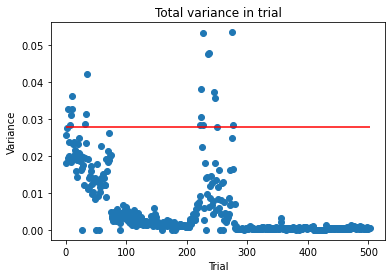

Forehead


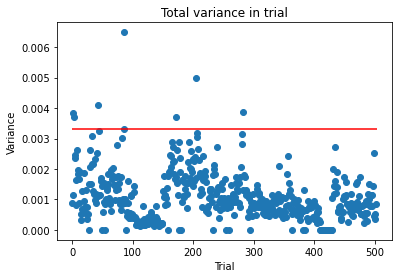

Cheek


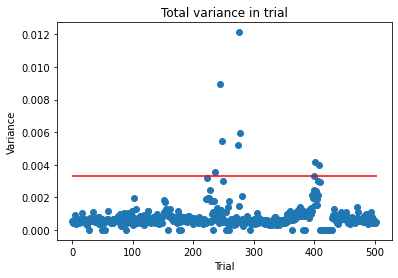

In [160]:

## outlier remove
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(bsnose,mask,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(bsfore,mask,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(bscheek,mask,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,eegBadTrials)))
validTrialInd = np.array([i for i in np.arange(full_room_temp_data.shape[0]) if i not in invalidTrials])
validPk = stimresponsechoice[validTrialInd]

# Nose
print('Nose')
bsnose = removeOutlier(bsnose, invalidTrials,baselineIndx)
plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
print('Forehead')
bsfore = removeOutlier(bsfore, invalidTrials,baselineIndx)
plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
print('Cheek')
bscheek = removeOutlier(bscheek, invalidTrials,baselineIndx)
plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)


# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])



bsnose = np.array(pd.DataFrame(bsnose).T.rolling(window=5).median().T) 
bsfore = np.array(pd.DataFrame(bsfore).T.rolling(window=5).median().T) 
bscheek = np.array(pd.DataFrame(bscheek).T.rolling(window=5).median().T)

# keepNoseTrials = bsnose
# keepForeheadTrials = bsfore
# keepLeftTrials = bsleft
# keepRightTrials = bsright
noseTrials = np.round(bsnose, 2)
foreheadTrials = np.round(bsfore, 2)
cheekTrials = np.round(bscheek,2)

## split condition
# nose
keepNose = noseTrials[np.where(validPk == 1)[0],:]
passNose = noseTrials[np.where(validPk == 0)[0],:]
# forehead
keepForehead = foreheadTrials[np.where(validPk == 1)[0],:]
passForehead = foreheadTrials[np.where(validPk == 0)[0],:]
# cheek
keepCheek = cheekTrials[np.where(validPk == 1)[0],:]
passCheek = cheekTrials[np.where(validPk == 0)[0],:]

passNose = np.concatenate([ses3['processed_pass_nose'],ses4['processed_pass_nose']],axis=0)
passForehead = np.concatenate([ses3['processed_pass_forehead'],ses4['processed_pass_forehead']],axis=0)
passCheek = np.concatenate([ses3['processed_pass_cheek'],ses4['processed_pass_cheek']],axis=0)
# passRightTrials = np.concatenate([ses3['processed_pass_right_cheek'],ses4['processed_pass_right_cheek']],axis=0)
keepNose = np.concatenate([ses3['processed_keep_nose'],ses4['processed_keep_nose']],axis=0)
keepForehead = np.concatenate([ses3['processed_keep_forehead'],ses4['processed_keep_forehead']],axis=0)
keepCheek = np.concatenate([ses3['processed_keep_cheek'],ses4['processed_keep_cheek']],axis=0)


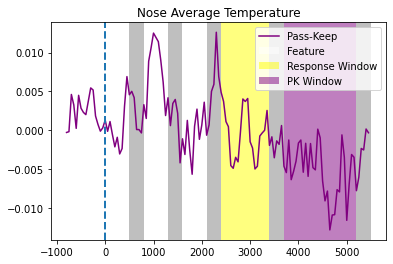

In [161]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),color='purple',label='Pass-Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend(loc='lower right')
plt.legend(loc='upper right')
# plt.xlim((0,134))
# plt.ylim((-.03,.03))
# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.legend(loc='lower right')
# plt.legend(loc='upper right')
# plt.xlim((0,134))
# plt.ylim((-.03,.03))

plt.title('Nose Average Temperature')
plt.show()

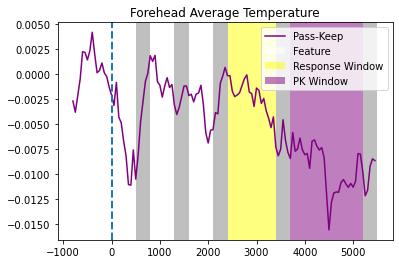

In [162]:
plt.plot(time[:130],np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130],color='purple',label='Pass-Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.legend(loc='lower right')
plt.legend(loc='upper right')
# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.legend(loc='upper right')
# plt.xlim((0,134))
# plt.ylim((-.03,.03))

plt.title('Forehead Average Temperature')
plt.show()

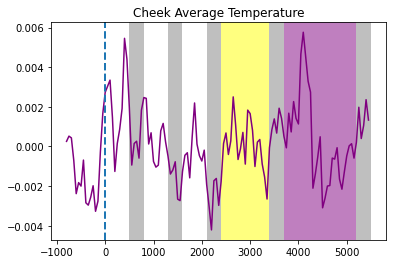

In [163]:
# passAvg = np.mean([np.mean(passRightTrials,axis=0),np.mean(passLeftTrials,axis=0)],axis=0)
# keepAvg = np.mean([np.mean(keepRightTrials,axis=0),np.mean(keepLeftTrials,axis=0)],axis=0)
plt.plot(time[:130],np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130],color='purple',label='Pass-Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.legend(loc='lower right')
# plt.legend(loc='upper right')
# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.xlim(0,134)
# plt.legend(loc='upper right')
# plt.ylim((-.03,.03))

plt.title('Cheek Average Temperature')
plt.show()

((42, 140), (56, 140))

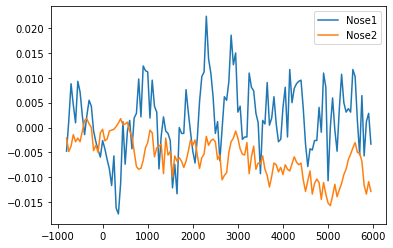

In [171]:
# noseTrials[np.where(validPk == 0)[0],:]
plt.plot(time[:passForehead.shape[1]],np.mean(passNose[:42],axis=0),label = 'Nose1')
plt.plot(time[:passForehead.shape[1]],np.mean(passNose[42:],axis=0),label = 'Nose2')
plt.legend()
ses3['processed_pass_nose'].shape,ses4['processed_pass_nose'].shape

In [165]:
passNose.shape

(98, 140)

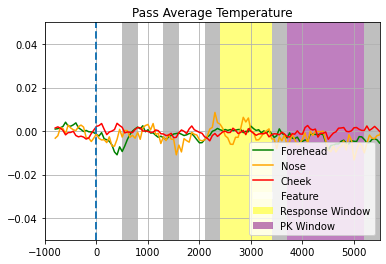

In [166]:
xnew = np.linspace(time[4], time[130], 1300)

# tck_s = splrep(time[4:130], np.mean(passNoseTrials,axis=0)[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Nose')
# tck_s = splrep(time[4:130], np.mean(passForeheadTrials,axis=0)[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Forehead')
# tck_s = splrep(time[4:130], passAvg[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Cheeks')
plt.plot(time[:passForehead.shape[1]],np.mean(passForehead,axis=0),color='green',label = 'Forehead')
plt.plot(time[:passForehead.shape[1]],np.mean(passNose,axis=0),color='orange',label = 'Nose')
plt.plot(time[:passForehead.shape[1]],np.mean(passCheek,axis=0),color='red',label = 'Cheek')

plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(-1000,5500)
plt.legend(loc='lower right')
# plt.legend(loc='upper right')

# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.xlim(0,134)

# plt.legend()
# plt.yticks(np.arange(-0.05,0.05,0.01))
plt.ylim((-.05,.05))
plt.grid()
plt.title('Pass Average Temperature')
plt.show()

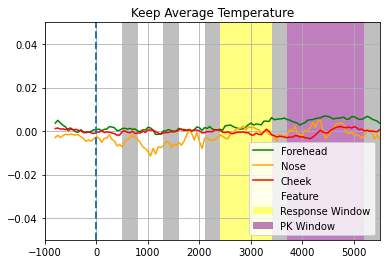

In [167]:
xnew = np.linspace(time[4], time[130], 1300)

# tck_s = splrep(time[4:130], np.mean(keepNoseTrials,axis=0)[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Nose')
# tck_s = splrep(time[4:130], np.mean(keepForeheadTrials,axis=0)[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Forehead')
# tck_s = splrep(time[4:130], keepAvg[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Cheeks')

plt.plot(time[:keepForehead.shape[1]],np.mean(keepForehead,axis=0),color='green',label = 'Forehead')
# plt.fill_between(time[:keepForeheadTrials.shape[1]],np.mean(keepForeheadTrials,axis=0) + np.std(keepForeheadTrials,axis=0),np.mean(keepForeheadTrials,axis=0) - np.std(keepForeheadTrials,axis=0))
plt.plot(time[:keepNose.shape[1]],np.mean(keepNose,axis=0),color='orange',label = 'Nose')
# plt.fill_between(time[:keepNoseTrials.shape[1]],np.mean(keepNoseTrials,axis=0) + np.std(keepNoseTrials,axis=0),np.mean(keepNoseTrials,axis=0) - np.std(keepNoseTrials,axis=0))
plt.plot(time[:keepForehead.shape[1]],np.mean(keepCheek,axis=0),color='red',label = 'Cheek')
# plt.fill_between(time[:keepForeheadTrials.shape[1]],np.mean((keepLeftTrials+keepRightTrials)/2,axis=0) + np.std((keepLeftTrials+keepRightTrials)/2,axis=0),np.mean((keepLeftTrials+keepRightTrials)/2,axis=0) - np.std((keepLeftTrials+keepRightTrials)/2,axis=0))

plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend(loc='lower right')
plt.xlim(-1000,5500)
# plt.legend(loc='upper right')

# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.xlim((0,134))
plt.legend()

# plt.yticks(np.arange(-0.05,0.05,0.01))
plt.ylim((-.05,.05))
plt.grid()
plt.title('Keep Average Temperature')
plt.show()

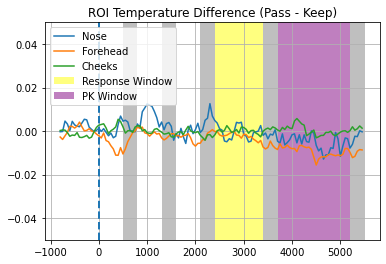

In [168]:
from scipy.interpolate import splrep, BSpline

# passAvg = np.mean([np.mean(passRightTrials,axis=0),np.mean(passLeftTrials,axis=0)],axis=0)
# keepAvg = np.mean([np.mean(keepRightTrials,axis=0),np.mean(keepLeftTrials,axis=0)],axis=0)
# passAvg = np.mean((passRightTrials + passLeftTrials)/2,axis=0)
# keepAvg = np.mean((keepRightTrials + keepLeftTrials)/2,axis=0)

xnew = np.linspace(time[4], time[130], 1300)

# tck_s = splrep(time[4:130], np.mean(passNoseTrials,axis=0)[4:130] - np.mean(keepNoseTrials,axis=0)[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Nose')
# tck_s = splrep(time[4:130], np.mean(passForeheadTrials,axis=0)[4:130] - np.mean(keepForeheadTrials,axis=0)[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Forehead')
# tck_s = splrep(time[4:130], passAvg[4:130] - keepAvg[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Cheeks')

plt.plot(time[:130],np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130],label='Nose')
plt.plot(time[:130],np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130],label='Forehead')
plt.plot(time[:130],np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130],label='Cheeks')

plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0)
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.legend(loc='lower right')
# plt.legend(loc='upper right')
plt.legend()
# plt.xlim((0,134))
plt.ylim((-.05,.05))
# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend(loc='upper left')
# plt.legend(loc='upper right')
# plt.xlim((0,134))
# plt.ylim((-.03,.03))
plt.grid()

plt.title('ROI Temperature Difference (Pass - Keep)')
plt.show()


In [169]:
noseDiff = np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]
foreheadDiff = np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]
cheekDiff = np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]


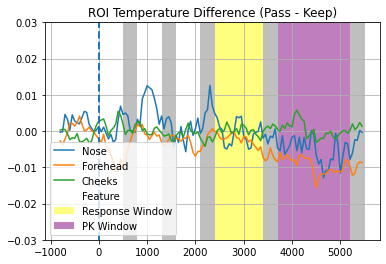

In [170]:
plt.plot(time[:130],np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130],label='Nose')
plt.plot(time[:130],np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130],label='Forehead')
plt.plot(time[:130],np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130],label='Cheeks')


# plt.xlim((0,134))
# plt.ylim((-.03,.03))
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend(loc='lower left')
# plt.legend(loc='upper right')
# plt.xlim((0,134))
plt.ylim((-.03,.03))
plt.grid()

plt.title('ROI Temperature Difference (Pass - Keep)')
plt.show()

In [140]:
timesOfInterest = {'prestart':(0,20),'features':(20,68),'response window': (68,94), 'pk window': (94,124)}
rois = {'Nose':noseDiff,'Forehead':foreheadDiff,'Cheek':cheekDiff}
for span in timesOfInterest:
    print(span)
    start = timesOfInterest[span][0]
    end = timesOfInterest[span][1]
    for roiName in rois:
        roi = rois[roiName]
        print(roiName)
        print(f'Mean and STD {np.nanmean(roi[start:end]),np.nanstd(roi[start:end])}')
        print(f'Maximum temperature change {np.nanmax(roi[start:end]) - np.nanmin(roi[start:end])}')
        # print(f'Average Diff {}')
        print()
    print()
    print()

prestart
Nose
Mean and STD (0.0024322561002131276, 0.002810377125112311)
Maximum temperature change 0.010407115827932668

Forehead
Mean and STD (8.867600365360323e-05, 0.0005709535329125738)
Maximum temperature change 0.0018789961289200122

Cheek
Mean and STD (4.8442868948718964e-05, 0.0015451745848385524)
Maximum temperature change 0.006081510156148059



features
Nose
Mean and STD (0.0032771156829483994, 0.004698499036720493)
Maximum temperature change 0.02349136618676874

Forehead
Mean and STD (-0.0027858908558421416, 0.0029621148560150163)
Maximum temperature change 0.012286981862467922

Cheek
Mean and STD (0.00015945551157699376, 0.0017254875481337313)
Maximum temperature change 0.006778304553955896



response window
Nose
Mean and STD (0.0033007230253978975, 0.003619329401379301)
Maximum temperature change 0.01228828672089078

Forehead
Mean and STD (-0.0026703927623852822, 0.002156924844259726)
Maximum temperature change 0.007906137184115524

Cheek
Mean and STD (0.000354938219972

In [141]:
from scipy.stats import ttest_ind
## TTest of diff between region diff
ttest_ind(noseDiff[4:],foreheadDiff[4:]),ttest_ind(foreheadDiff[4:],cheekDiff[4:]),ttest_ind(noseDiff[4:],cheekDiff[4:])

(Ttest_indResult(statistic=14.22102024535612, pvalue=4.975912637516371e-34),
 Ttest_indResult(statistic=-12.08526328053814, pvalue=8.699849726105793e-27),
 Ttest_indResult(statistic=6.071613062667586, pvalue=4.677119945907688e-09))

In [142]:
## Ttest of diff within region between p or k
passCheekTrials = (passLeftTrials + passRightTrials) / 2
keepCheekTrials = (keepLeftTrials + keepRightTrials) / 2
ttest_ind(np.mean(keepNoseTrials,axis=0)[4:130],np.mean(passNoseTrials,axis=0)[4:130]),ttest_ind(np.mean(keepForeheadTrials,axis=0)[4:130],np.mean(passForeheadTrials,axis=0)[4:130]),ttest_ind(np.mean(keepCheekTrials,axis=0)[4:130],np.mean(passCheekTrials,axis=0)[4:130])

NameError: name 'passLeftTrials' is not defined

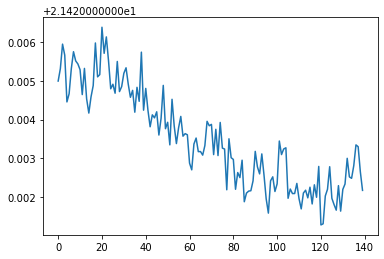

In [ ]:
yerr0 = np.nanmean(full_room_temp_data,axis=0) + np.nanstd(full_room_temp_data,axis=0)
yerr1 = np.nanmean(full_room_temp_data,axis=0) - np.nanstd(full_room_temp_data,axis=0)
plt.plot(np.mean(full_room_temp_data,axis=0))
# plt.fill_between(np.arange(full_room_temp_data.shape[1]), yerr0, yerr1, color='C0', alpha=0.5)
plt.show()

In [ ]:
np.nanstd(keepNose,axis=0)

/home/shane/anaconda3/envs/psychopy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


array([       nan,        nan,        nan,        nan, 0.03875108,
       0.03683156, 0.03634061, 0.03000263, 0.03008877, 0.03057026,
       0.02854995, 0.02738005, 0.02681351, 0.02738776, 0.02967619,
       0.03075567, 0.03458246, 0.03141603, 0.03574744, 0.03934803,
       0.03901841, 0.03492343, 0.03647878, 0.03983139, 0.04271809,
       0.04323963, 0.04227133, 0.04322185, 0.04476229, 0.04419047,
       0.04742165, 0.04823267, 0.04844206, 0.05115703, 0.05224646,
       0.05303936, 0.05158199, 0.04786053, 0.05624716, 0.05453742,
       0.05384994, 0.05375525, 0.0547476 , 0.0571235 , 0.05831857,
       0.05560765, 0.05851016, 0.04966688, 0.05107621, 0.05377896,
       0.05395454, 0.05380575, 0.05384234, 0.05406084, 0.05630167,
       0.05562323, 0.05137459, 0.05104931, 0.04686101, 0.04843756,
       0.04670824, 0.04782354, 0.05134917, 0.05222693, 0.0541053 ,
       0.0527062 , 0.05304032, 0.05785086, 0.05811501, 0.0530062 ,
       0.05029452, 0.05240487, 0.04819696, 0.04939961, 0.04942

In [ ]:
passAvg == 

SyntaxError: invalid syntax (3017820678.py, line 1)

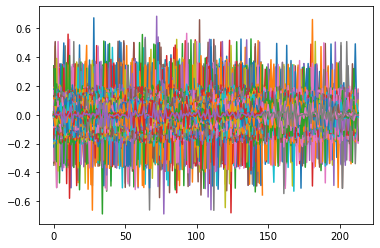

In [ ]:
full_nose_roi_data = ses3['full_nose_data']
for i in full_nose_roi_data:
    plt.plot(np.diff(i))
plt.show()

In [ ]:
for i in full_nose_roi_data:
    for j in np.where(np.diff(i) > .4)[0]:
        print(i[j-4:j+4])


[28.52222222 28.19333333 28.35155556 28.37111111 28.21555556 28.692
 28.52844444 28.51288889]
[28.36177778 28.24355556 28.12133333 28.11733333 28.11866667 28.57555556
 28.096      28.12444444]
[28.16444444 28.18355556 28.33555556 28.16844444 28.004      28.48355556
 28.32444444 28.15422222]
[27.96488889 28.13688889 28.13377778 27.96044444 28.14666667 28.62222222
 28.10888889 28.11066667]
[28.21866667 28.51822222 28.19866667 28.04222222 28.02622222 28.50666667
 28.04488889 28.17688889]
[28.34133333 28.33466667 28.50266667 28.18088889 28.00933333 28.46577778
 28.144      28.46088889]
[28.13733333 27.97777778 28.15244444 28.15377778 27.988      28.46711111
 28.29822222 28.65911111]
[28.42977778 28.28222222 28.11288889 28.27422222 28.12488889 28.61688889
 28.61511111 28.30133333]
[28.09422222 28.28       28.29555556 28.29733333 28.15288889 28.61422222
 28.13155556 28.14222222]
[28.36266667 28.17422222 28.19155556 28.01377778 28.01066667 28.49288889
 28.00444444 28.16355556]
[28.16977778 28

In [ ]:
ses3['processed_pass_nose'].shape,ses3['pass_nose_data'].shape,ses3['pass_invalif_trials']
# outdict['processed_pass_forehead'] = passForeheadTrials
# outdict['processed_pass_left_cheek'] = passLeftTrials
# outdict['processed_pass_right_ceek'] = passRightTrials
# outdict['processed_keep_nose'] = keepNoseTrials
# outdict['processed_keep_forehead'] = keepForeheadTrials
# outdict['processed_keep_left_cheek'] = keepLeftTrials
# outdict['processed_keep_right_cheek'] = keepRightTrials
# outdict['keep_invalid_trials'] = keepInvalidTrials
# outdict['pass_invalif_trials'] = passInvalidTrials
# outdict['keep_trial_ind'] = validKeepTrialInd 
# outdict['pass_trial_ind'] = validPassTrialInd
# outdict['full_nose_data'] = full_nose_roi_data
# outdict['full_bridge_data'] = full_bridge_roi_data
# outdict['full_forehead_data'] = full_forehead_roi_data
# outdict['full_left_cheek_data'] = full_left_cheek_roi_data
# outdict['full_right_cheek_data'] = full_right_cheek_roi_data
# outdict['full_room_temp_data'] = full_room_temp_data
# outdict = pass_nose_roi_data
# outdict['pass_bridge_data'] = pass_bridge_roi_data
# outdict['pass_forehead_data'] = pass_forehead_roi_data

((43, 215), (53, 215), array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 23]))

In [194]:
k3 = np.array([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False])
p3 = np.array([False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, 
      True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, 
      True, False, False, False, False])

k4 = np.array([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, 
      False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, 
      False, False, False, False, False, False, True, False, True, False, False, False, False, False, True, True, False, True, False, 
      False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, 
      False, False, False, False, False, False, False])
p4 = np.array([False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, 
      False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, True, False, True, 
      False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
      False, False])
passBadTrials = np.concatenate((p3,p4),axis=0)
keepBadTrials = np.concatenate((k3,k4),axis=0)
passValid = np.where(passBadTrials == False)
keepValid = np.where(keepBadTrials == False)
passInvalid = np.where(passBadTrials == True)
keepInvalid = np.where(keepBadTrials == True)
keepNose = np.concatenate((ses3['keep_nose_data'],ses4['keep_nose_data']),axis=0)#[keepValid]
passNose = np.concatenate((ses3['pass_nose_data'],ses4['pass_nose_data']),axis=0)#[passValid]
keepBridge = np.concatenate((ses3['keep_bridge_data'],ses4['keep_bridge_data']),axis=0)#[keepValid]
passBridge = np.concatenate((ses3['pass_bridge_data'],ses4['pass_bridge_data']),axis=0)#[passValid]
keepForehead = np.concatenate((ses3['keep_forehead_data'],ses4['keep_forehead_data']),axis=0)#[keepValid]
passForehead = np.concatenate((ses3['pass_forehead_data'],ses4['pass_forehead_data']),axis=0)#[passValid]
keepCheek = ((np.concatenate((ses3['keep_left_cheek_data'],ses4['keep_left_cheek_data']),axis=0) + np.concatenate((ses3['keep_right_cheek_data'],ses4['keep_right_cheek_data']),axis=0))/2)#[keepValid]
passCheek = ((np.concatenate((ses3['pass_left_cheek_data'],ses4['pass_left_cheek_data']),axis=0) + np.concatenate((ses3['pass_right_cheek_data'],ses4['pass_right_cheek_data']),axis=0))/2)#[passValid]
keepRoom = np.concatenate((ses3['keep_room_temp_data'],ses4['keep_room_temp_data']),axis=0)#[keepValid]
passRoom = np.concatenate((ses3['pass_room_temp_data'],ses4['pass_room_temp_data']),axis=0)#[passValid]

keepNose -= keepRoom
passNose -= passRoom
keepBridge -= keepRoom
passBridge -= passRoom
keepForehead -= keepRoom
passForehead -= passRoom
keepCheek -= keepRoom
passCheek -= passRoom

In [195]:
## Split -> baseline -> outlier
keepbsnose = baselinecorrect(keepNose,range(20))
keepbsfore = baselinecorrect(keepForehead,range(20))
keepbsbridge = baselinecorrect(keepBridge,range(20))
keepbscheek = baselinecorrect(keepCheek,range(20))
passbsnose = baselinecorrect(passNose,range(20))
passbsbridge = baselinecorrect(passBridge,range(20))
passbsfore = baselinecorrect(passForehead,range(20))
passbscheek = baselinecorrect(passCheek,range(20))

(370, 148)
(370,)
(370, 148)
(370,)
(370, 148)
(370,)
(370, 148)
(370,)
(133, 215)
(133,)
(133, 215)
(133,)
(133, 215)
(133,)
(133, 215)
(133,)


Nose


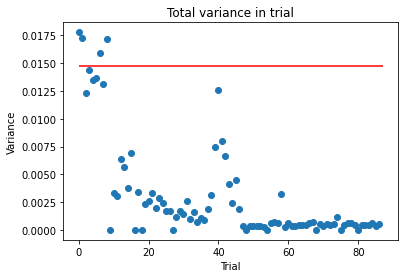

Bridge


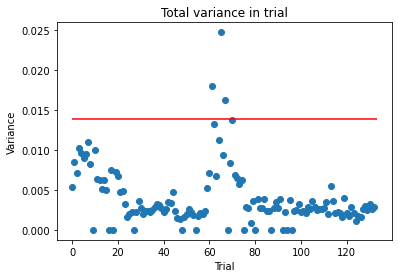

Forehead


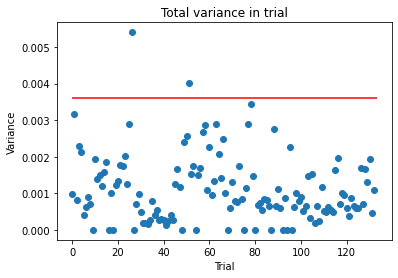

Cheek


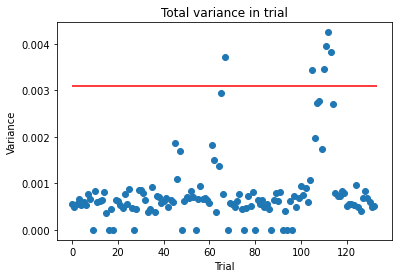

Nose


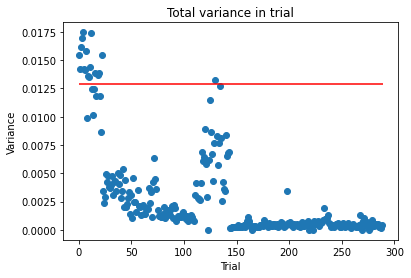

Bridge


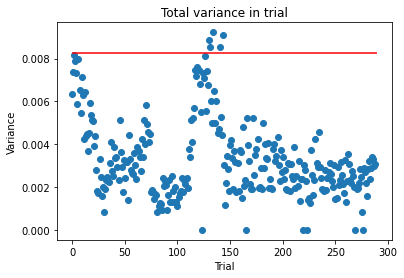

Forehead


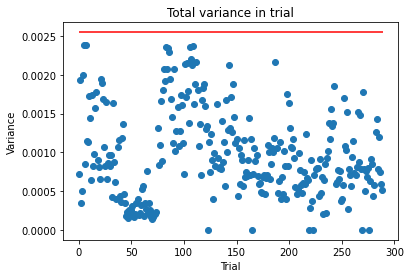

Cheek


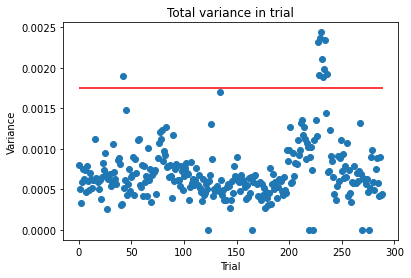

In [213]:
mask = passBadTrials
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(passbsnose,mask,varThresh)
bridgeTrialsVar,stdBridgeTrials,medianVarBridgeTrials,bridgeTrialOutlier = getOutlier(passbsbridge,mask,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(passbsfore,mask,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(passbscheek,mask,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,bridgeTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,passInvalid[0])))
validTrialInd = np.array([i for i in np.arange(passRoom.shape[0]) if i not in invalidTrials])
# validPk = stimresponsechoice[validTrialInd]

# Nose
print('Nose')
bsnose = removeOutlier(passbsnose, invalidTrials,baselineIndx)
plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Bridge
print('Bridge')
bsbridge = removeOutlier(passbsbridge, invalidTrials,baselineIndx)
plotCleanup(bridgeTrialsVar,medianVarBridgeTrials, stdBridgeTrials,varThresh = 3)

# Forehead
print('Forehead')
bsfore = removeOutlier(passbsfore, invalidTrials,baselineIndx)
plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
print('Cheek')
bscheek = removeOutlier(passbscheek, invalidTrials,baselineIndx)
plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)


# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])



bsnose = np.array(pd.DataFrame(bsnose).T.rolling(window=5).median().T) 
bsbridge = np.array(pd.DataFrame(bsbridge).T.rolling(window=5).median().T)
bsfore = np.array(pd.DataFrame(bsfore).T.rolling(window=5).median().T) 
bscheek = np.array(pd.DataFrame(bscheek).T.rolling(window=5).median().T)

# keepNoseTrials = bsnose
# keepForeheadTrials = bsfore
# keepLeftTrials = bsleft
# keepRightTrials = bsright
passNose = np.round(bsnose, 3)
passBridge = np.round(bsbridge,3)
passForehead = np.round(bsfore, 3)
passCheek = np.round(bscheek,3)


mask = keepBadTrials
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(keepbsnose,mask,varThresh)
bridgeTrialsVar,stdBridgeTrials,medianVarBridgeTrials,bridgeTrialOutlier = getOutlier(keepbsbridge,mask,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(keepbsfore,mask,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(keepbscheek,mask,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,bridgeTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,keepInvalid[0])))
validTrialInd = np.array([i for i in np.arange(keepRoom.shape[0]) if i not in invalidTrials])
# validPk = stimresponsechoice[validTrialInd]

# Nose
print('Nose')
bsnose = removeOutlier(keepbsnose, invalidTrials,baselineIndx)
plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Bridge
print('Bridge')
bsbridge = removeOutlier(keepbsbridge, invalidTrials,baselineIndx)
plotCleanup(bridgeTrialsVar,medianVarBridgeTrials, stdBridgeTrials,varThresh = 3)

# Forehead
print('Forehead')
bsfore = removeOutlier(keepbsfore, invalidTrials,baselineIndx)
plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
print('Cheek')
bscheek = removeOutlier(keepbscheek, invalidTrials,baselineIndx)
plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)


# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])



bsnose = np.array(pd.DataFrame(bsnose).T.rolling(window=5).median().T) 
bsbridge = np.array(pd.DataFrame(bsbridge).T.rolling(window=5).median().T)
bsfore = np.array(pd.DataFrame(bsfore).T.rolling(window=5).median().T) 
bscheek = np.array(pd.DataFrame(bscheek).T.rolling(window=5).median().T)

# keepNoseTrials = bsnose
# keepForeheadTrials = bsfore
# keepLeftTrials = bsleft
# keepRightTrials = bsright
keepNose = np.round(bsnose, 3)
keepBridge = np.round(bsbridge,3)
keepForehead = np.round(bsfore, 3)
keepCheek = np.round(bscheek,3)

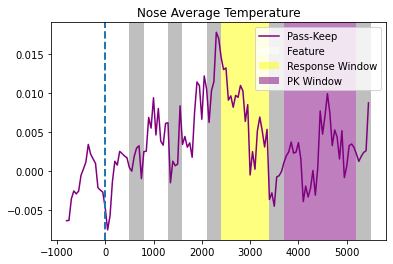

In [214]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),color='purple',label='Pass-Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend(loc='lower right')
plt.legend(loc='upper right')
# plt.xlim((0,134))
# plt.ylim((-.03,.03))
# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.legend(loc='lower right')
# plt.legend(loc='upper right')
# plt.xlim((0,134))
# plt.ylim((-.03,.03))

plt.title('Nose Average Temperature')
plt.show()

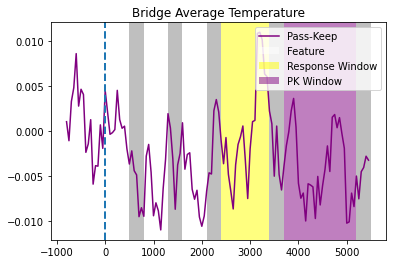

In [220]:
plt.plot(time[:130],(np.mean(passBridge,axis=0)[:130] - np.mean(keepBridge,axis=0)[:130]),color='purple',label='Pass-Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend(loc='lower right')
plt.legend(loc='upper right')
# plt.xlim((0,134))
# plt.ylim((-.03,.03))
# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.legend(loc='lower right')
# plt.legend(loc='upper right')
# plt.xlim((0,134))
# plt.ylim((-.03,.03))

plt.title('Bridge Average Temperature')
plt.show()

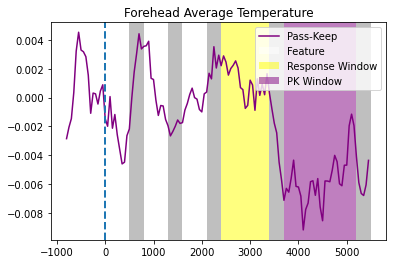

In [215]:
plt.plot(time[:130],np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130],color='purple',label='Pass-Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.legend(loc='lower right')
plt.legend(loc='upper right')
# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.legend(loc='upper right')
# plt.xlim((0,134))
# plt.ylim((-.03,.03))

plt.title('Forehead Average Temperature')
plt.show()

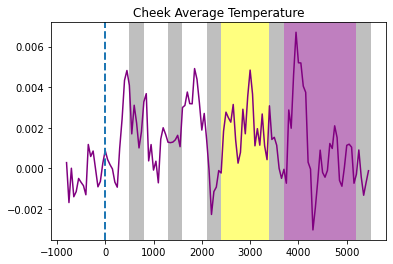

In [216]:
# passAvg = np.mean([np.mean(passRightTrials,axis=0),np.mean(passLeftTrials,axis=0)],axis=0)
# keepAvg = np.mean([np.mean(keepRightTrials,axis=0),np.mean(keepLeftTrials,axis=0)],axis=0)
plt.plot(time[:130],np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130],color='purple',label='Pass-Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.legend(loc='lower right')
# plt.legend(loc='upper right')
# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.xlim(0,134)
# plt.legend(loc='upper right')
# plt.ylim((-.03,.03))

plt.title('Cheek Average Temperature')
plt.show()

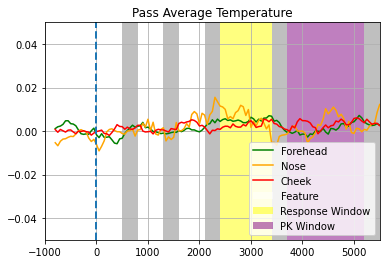

In [222]:
xnew = np.linspace(time[4], time[130], 1300)

# tck_s = splrep(time[4:130], np.mean(passNoseTrials,axis=0)[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Nose')
# tck_s = splrep(time[4:130], np.mean(passForeheadTrials,axis=0)[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Forehead')
# tck_s = splrep(time[4:130], passAvg[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Cheeks')
plt.plot(time[:passForehead.shape[1]],np.mean(passForehead,axis=0),color='green',label = 'Forehead')
plt.plot(time[:passForehead.shape[1]],np.mean(passNose,axis=0),color='orange',label = 'Nose')
plt.plot(time[:passForehead.shape[1]],np.mean(passCheek,axis=0),color='red',label = 'Cheek')

plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(-1000,5500)
plt.legend(loc='lower right')
# plt.legend(loc='upper right')

# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.xlim(0,134)

# plt.legend()
# plt.yticks(np.arange(-0.05,0.05,0.01))
plt.ylim((-.05,.05))
plt.grid()
plt.title('Pass Average Temperature')
plt.show()

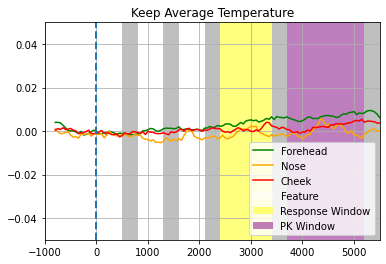

In [223]:
xnew = np.linspace(time[4], time[130], 1300)

# tck_s = splrep(time[4:130], np.mean(keepNoseTrials,axis=0)[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Nose')
# tck_s = splrep(time[4:130], np.mean(keepForeheadTrials,axis=0)[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Forehead')
# tck_s = splrep(time[4:130], keepAvg[4:130], s=len(time[4:130]))
# plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label='Cheeks')

plt.plot(time[:keepForehead.shape[1]],np.mean(keepForehead,axis=0),color='green',label = 'Forehead')
# plt.fill_between(time[:keepForeheadTrials.shape[1]],np.mean(keepForeheadTrials,axis=0) + np.std(keepForeheadTrials,axis=0),np.mean(keepForeheadTrials,axis=0) - np.std(keepForeheadTrials,axis=0))
plt.plot(time[:keepNose.shape[1]],np.mean(keepNose,axis=0),color='orange',label = 'Nose')
# plt.fill_between(time[:keepNoseTrials.shape[1]],np.mean(keepNoseTrials,axis=0) + np.std(keepNoseTrials,axis=0),np.mean(keepNoseTrials,axis=0) - np.std(keepNoseTrials,axis=0))
plt.plot(time[:keepForehead.shape[1]],np.mean(keepCheek,axis=0),color='red',label = 'Cheek')
# plt.fill_between(time[:keepForeheadTrials.shape[1]],np.mean((keepLeftTrials+keepRightTrials)/2,axis=0) + np.std((keepLeftTrials+keepRightTrials)/2,axis=0),np.mean((keepLeftTrials+keepRightTrials)/2,axis=0) - np.std((keepLeftTrials+keepRightTrials)/2,axis=0))

plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend(loc='lower right')
plt.xlim(-1000,5500)
# plt.legend(loc='upper right')

# plt.axvline(x=20,linestyle = '--',lw=2)
# plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.xlim((0,134))
plt.legend()

# plt.yticks(np.arange(-0.05,0.05,0.01))
plt.ylim((-.05,.05))
plt.grid()
plt.title('Keep Average Temperature')
plt.show()

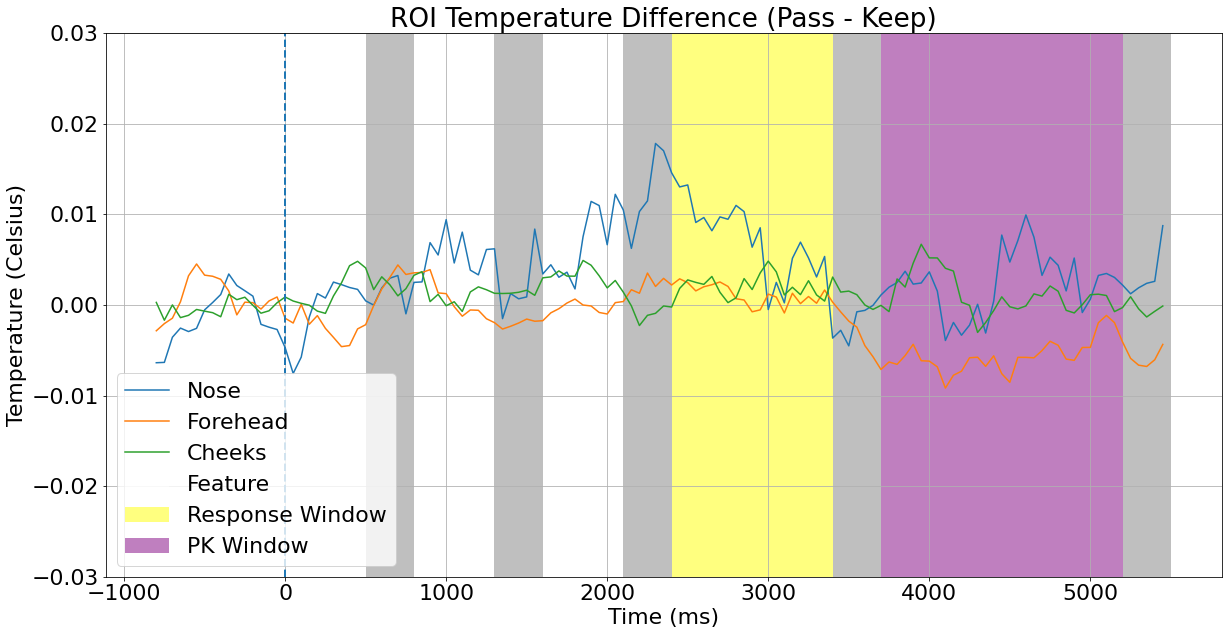

In [231]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time[:130],np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130],label='Nose')
plt.plot(time[:130],np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130],label='Forehead')
plt.plot(time[:130],np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130],label='Cheeks')


# plt.xlim((0,134))
# plt.ylim((-.03,.03))
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend(loc='lower left')
# plt.legend(loc='upper right')
# plt.xlim((0,134))
plt.xlabel('Time (ms)')
plt.ylabel('Temperature (Celsius)')
plt.ylim((-.03,.03))
plt.grid()

plt.title('ROI Temperature Difference (Pass - Keep)')
plt.savefig(f'../figures/subject{sub}/Subject{sub}ROIDiff.png',facecolor = 'white',format = 'png')
plt.show()